# Определение стоимости автомобилей с пробегом

## Описание проекта

Чтобы привлечь новых клиентов, сервис по продаже автомобилей с пробегом разрабатывает приложение, в котором можно будет узнать рыночную стоимость своего автомобиля. 

### Цель проекта

Построить модель для определения стоимости автомобиля по его характеристикам.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

### Задачи проекта

- Подготовить исходные данные для обучения моделей.

- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели подобрать оптимальные гиперпараметры.

- Проанализировать время обучения, время предсказания и качество моделей.

- Опираясь на критерии заказчика, выбрать лучшую модель и проверить её качество на тестовой выборке.

### Описание данных

Исторические данные, включающие технические характеристики, комплектации и цены автомобилей. Данные находятся в файле [`/datasets/autos.csv`](https://<LINK_REMOVED>/datasets/autos.csv).

Прогнозирующие признаки:
- `DateCrawled` — дата скачивания анкеты из базы;
- `VehicleType` — тип автомобильного кузова;
- `RegistrationYear` — год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` — мощность (л.с.);
- `Model` — модель автомобиля;
- `Kilometer` — пробег (км);
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип топлива;
- `Brand` — марка автомобиля;
- `Repaired` — была машина в ремонте или нет;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя);
- `LastSeen` — дата последней активности пользователя;

Целевой признак:
- `Price` — цена (евро).

## Установка и обновление библиотек

In [1]:
# обновляем версии библиотек и устанавливаем дополнительные библиотеки
%pip install matplotlib==3.5.0 scikit-learn==1.4.0 shap==0.46.0 \
    lightgbm==4.3.0 catboost==1.2.3 optuna-integration[sklearn]==4.1.0 -q

Note: you may need to restart the kernel to use updated packages.


## Импорты

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error

# классы моделей
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Optuna
from optuna.integration import OptunaSearchCV
from optuna import distributions
import optuna.logging
from optuna.exceptions import ExperimentalWarning

## Настройки

In [3]:
# фиксируем случайное состояние для воспроизводимости результатов
RANDOM_STATE = 42

In [4]:
# отображать таблицы pandas полностью
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [5]:
# пропустить повторный поиск оптимальных гиперпараметров моделей
SKIP_HYPERPARAMETER_SEARCH = True

# выполнить повторный поиск оптимальных гиперпараметров моделей
# SKIP_HYPERPARAMETER_SEARCH = False

In [6]:
# Настройки Optuna

# скрыть предупреждения об экспериментальном статусе
warnings.filterwarnings('ignore', category=ExperimentalWarning)

# скрыть вывод optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# показать вывод optuna
# optuna.logging.set_verbosity(optuna.logging.INFO)

## Пользовательские функции

In [7]:
def plot_missing(data):
    """
    Считает долю (в %) пропущенных значений в каждом столбце
    и строит диаграмму.
    """
    # доля (в %) пропущенных значений в каждом столбце
    missing_ratio = (
        data
        .loc[:, data.isna().any()]
        .isna()
        .mean()
        .mul(100)
        .sort_values()
    )
    # строим и оформляем диаграмму
    labels = missing_ratio.round(2).astype(str) + ' %'
    ax = missing_ratio.plot.barh(figsize=(9, 4))
    plt.xlim(0, 100)
    plt.xticks(range(0, 101, 10))
    plt.title('Доля пропущенных значений в столбцах')
    plt.xlabel('% пропущенных значений')
    plt.ylabel('столбцы')
    
    for bar in ax.containers[0]:
        width = bar.get_width()
        label = bar.get_y() + bar.get_height() / 2
        plt.text(width, label, s=f'{width:.2f} %')
        
    plt.show()

In [8]:
def unique_values(data, columns=None, show_counts=False):
    """
    Для каждого из указанных столбцов таблицы выводит 
    отсортированный список уникальных значений в этом столбце.
    """
    # если не указаны столбцы, выбираем все
    if columns is None:
        columns = data.columns
    
    # если указан один столбец, преобразуем в список
    if isinstance(columns, str):
        columns = [columns]

    # выводим список уникальных значений в каждом из выбранных столбцов
    for col in columns:
        try:
            if show_counts:
                print(f'Уникальные значения в столбце \'{col}\' и их количество:')
                print_data = data[col].value_counts(sort=False, dropna=False).sort_index()
                if print_data.index.is_object():
                    print_data.index = print_data.index.map("'{}'".format, na_action='ignore')
                print(print_data.to_string())
            else:
                print(f'Уникальные значения в столбце \'{col}\':\n'
                      f'{data[col].sort_values().unique().tolist()}')
        except:
            print(f'Столбца {col} не существует.')
        print()

In [9]:
def cat_hist(data, column):
    """
    Строит гистограмму распределения для категориальных признаков.
    """
    (data[column]
        .value_counts()
        .sort_index()
        .plot(kind='bar', figsize=(10, 4))
    )
    plt.ylabel('Количество объектов')
    plt.title('Гистограмма распределения значений признака\n' + column)

In [10]:
def num_stat_plots(data, column, show_boxplot=True):
    """
    Строит гистограмму распределения и диаграмму размаха (опционально)
    для количественных признаков.
    """
    # если нет такого столбца
    if column not in data.columns:
        print(f"В таблице отсутствует столбец '{column}'")
        return None  
    # если признак количественный
    elif data[column].dtype in ['int64', 'float64']:
        # если признак дискретный
        if data[column].dtype == 'int64' and data[column].nunique() <= 30:
            discrete = True
            kde = False
        else:
            discrete = False
            kde = True  
        # создаём область построения графиков
        if show_boxplot:
            title = (
                'Диаграмма размаха и гистограмма распределения значений признака\n' 
                + column)
            fig, axes = plt.subplots(
                nrows=2, 
                ncols=1, 
                figsize=(10, 5),
                gridspec_kw={'height_ratios': [1, 4]},
                constrained_layout=True, 
            )
            a_box = axes[0]
            a_hist = axes[1]
            # строим диаграмму размаха
            sns.boxplot(
                data=data, 
                x=column, 
                ax=axes[0]
            )
            a_box.set_yticklabels([])

        else:
            title = 'Гистограмма распределения значений признака\n' + column
            fig, a_hist = plt.subplots(
                nrows=1, 
                ncols=1, 
                figsize=(10, 4),
                constrained_layout=True, 
            )           
            axes = [a_hist]
        # строим гистограмму распределения
        sns.histplot(
            data=data, 
            x=column, 
            discrete=discrete, 
            kde=kde, 
            stat='count', 
            ax=a_hist
        )
        # добавляем линии: среднее и медиана
        a_hist.axvline(
            x=data[column].mean(), 
            color='red', 
            label='Среднее'
        )
        a_hist.axvline(
            x=data[column].median(), 
            color='red', 
            label='Медиана', 
            linestyle='--'
        )   
        a_hist.legend()
        a_hist.set_ylabel('Количество объектов')
        
        # если признак дискретный, то делаем метки на оси с шагом 1
        if discrete:
            x_min, x_max = data[column].agg(['min', 'max']).tolist()
            for ax in axes:
                ax.set_xticks(range(x_min, x_max+1))     
    else:
        print('Неподходящий тип данных аргумента.')
    # заголовок
    fig.suptitle(title)
    
    return fig, axes

In [11]:
def corr_matrix(data, features=None, method='pearson', interval_cols=None):
    """
    Выводит матрицу корреляции количественных признаков features в данных data
    в виде тепловой карты.
    Дополнительный параметр:
    method - метод расчёта корреляции, по умолчанию 'pearson':
        'pearson' - корреляция Пирсона, 
        'spearman' - корреляция Спирмена,
        'kendall' - корреляция Кендалла,
        'phik' - корреляция фи.
    """
    if method == 'pearson':
        method_name = 'Пирсона'
    elif method == 'spearman':
        method_name = 'Спирмена'
    elif method == 'kendall':
        method_name = 'Кендалла'
    elif method == 'phik':
        method_name = '$\phi_k$'
    else:
        print('Неправильно указан метод расчёта корреляций.')
        return None

    if features is None:
        features = data.columns
         
    # расчёт матрицы корреляции
    if method in [ 'pearson', 'spearman', 'kendall']:
        corr_data = data[features].corr(method=method)
        vmin = -1
        vmax = 1
        center = 0
        cmap='bwr'
    elif method == 'phik':
        corr_data = data[features].phik_matrix(interval_cols=interval_cols)
        vmin = 0
        vmax = 1
        center = 0.5
        cmap='Greens'
    
    # строим тепловую карту по матрице корреляции
    ax = sns.heatmap(corr_data, 
                     annot=True,
                     fmt='.2f',
                     square=True,
                     cmap=cmap, 
                     vmin=vmin,
                     vmax=vmax,
                     center=center,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Коэффициенты корреляции {method_name}')

    return ax

In [12]:
def encode_features(encoder, cat_columns, X_train, X_test):
    """
    Кодирует категориальные признаки в тренировочной и тестовой выборках.
    
    encoder - кодировщик,
    cat_columns - список категориальных признаков для кодирования.
    """
    # обучаем кодировщик и кодируем категориальные признаки в тренировочной выборке
    cat_features_train_encoded = encoder.fit_transform(X_train[cat_columns])
    
    # кодируем категориальные признаки в тестовой выборке
    cat_features_test_encoded = encoder.transform(X_test[cat_columns])
    
    # получаем от кодировщика список названий кодированных признаков 
    encoded_cat_columns = encoder.get_feature_names_out(cat_columns)
    
    # объединяем датафреймы с количественными и кодированными категориальными признаками
    X_train_encoded = pd.concat(
        [
            X_train[X_train.columns.drop(cat_columns)].reset_index(drop=True),
            pd.DataFrame(
                cat_features_train_encoded, 
                columns=encoded_cat_columns, 
                dtype='int'
            )
        ],
        axis=1
    )
    X_test_encoded = pd.concat(
        [
            X_test[X_test.columns.drop(cat_columns)].reset_index(drop=True),
            pd.DataFrame(
                cat_features_test_encoded, 
                columns=encoded_cat_columns, 
                dtype='int'
            )
        ],
        axis=1
    )
    return X_train_encoded, X_test_encoded

In [13]:
def cross_val_rmse(model, X, y, **kwargs):
    """
    Расчёт RMSE модели на тренировочной выборке при кросс-валидации.
    """
    cv_score = cross_val_score(
        model, 
        X, y,
        scoring='neg_root_mean_squared_error',
        cv=5, 
        **kwargs
    )

    return -cv_score.mean()

In [14]:
def timing(model, **fit_params):
    """
    Измеряет время обучения и предсказания модели.
    """
    # обучаем модель на тренировочной выборке
    train_time = %timeit -t -o -q \
        model.fit(X_train, y_train, **fit_params)

    # делаем предсказание на для случайной записи из тестовой выборки
    pred_time = %timeit -t -o -q \
        y_pred = model.predict(X_test.sample(n=1))

    print('Время обучения модели:\n', train_time)
    print()
    print('Время предсказания модели:\n', pred_time)

    return train_time.average, pred_time.average

In [15]:
def plot_residuals(y_test, y_pred):
    """
    Строит графики для визуального анализа остатков:
    - гистограмму распределения остатков,
    - диаграмму рассеяния остатков и предсказаний модели.
    """
    # остатки модели
    residuals = y_test - y_pred
    # среднее значение остатков
    residuals_mean = residuals.mean()

    # создаём область построения графиков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)
    
    # строим гистограмму распределения остатков
    sns.histplot(x=residuals, ax=axes[0], kde=True)
    axes[0].axvline(x=residuals_mean, color='red', label='Среднее значение:\n'+str(residuals_mean.round(4)))
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Количество')
    axes[0].legend()
    
    # строим диаграмму рассеяния остатков и предсказаний модели
    sns.residplot(x=y_pred, y=residuals, ax=axes[1], lowess=True, line_kws=dict(color="r"))
    axes[1].set_xlim(axes[1].get_xlim() * np.array([0.99, 1.01]))
    axes[1].set_title('Анализ разброса остатков')
    axes[1].set_title('Анализ разброса остатков')
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    
    # заголовок
    fig.suptitle('Анализ остатков')

    return fig, axes

In [16]:
def plot_feature_importance(importance, feature_names):
    """
    Строит график важности признаков.
    """
    # формируем таблицу
    feature_df = (
        pd.DataFrame({'признак': feature_names, 'значение': importance})
        .sort_values(by='значение', key=lambda x: abs(x), ascending=False)
        .reset_index(drop=True)
    )
    # визуализируем данные в таблице
    sns.barplot(data=feature_df, x='значение', y='признак')

## Подготовка данных

### Загрузка данных

In [17]:
# путь к файлам по умолчанию
path_default = '/datasets/'
# путь к файлам на локальном компьютере
path_local_rel = '~/datasets/'
path_local = os.path.expanduser(path_local_rel)
# путь к файлам на внешнем сервере
path_remote = 'https://<LINK_REMOVED>/datasets/'

# определение расположения файлов
if os.path.exists(path_default):
    path = path_default
    source = 'по умолчанию'
elif os.path.exists(path_local):
    path = path_local_rel
    source = 'локальный путь'
else:
    path = path_remote
    source = 'сетевой путь'
    
# загрузка данных из CSV файлов
data = pd.read_csv(path + 'autos.csv', 
                   parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

print(f'Данные успешно загружены из источника: {source}: {path}')

Данные успешно загружены из источника: локальный путь: ~/datasets/


### Знакомство с данными

In [18]:
# первые 5 строк таблицы
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [19]:
# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

**Выводы:**

- Датасет содержит ≈ 354 тыс. записей.
- В данных имеются пропущенные значения.

### Предобработка данных

#### Переименование столбцов

Переименуем столбцы в таблице в соответствие с форматом "snake_case".

In [20]:
# приводим названия столбцов к формату snake_case
data.columns = (
    data.columns
    .to_series()
    .str.findall(r'[A-Z][^A-Z]*')
    .str.join('_')
    .str.lower()
    .reset_index(drop=True)
)

# выводим названия столбцов
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Удаление полных дубликатов

Найдём и удалим из данных полные дубликаты записей.

In [21]:
print('Количество полных дубликатов записей:', data.duplicated().sum())

Количество полных дубликатов записей: 4


In [22]:
# удаляем полные дубликаты
data = data.drop_duplicates()

#### Удаление неинформативных признаков

Удалим из данных неинформативные признаки, которые не могут влиять не целевой — цену автомобиля:
- дата скачивания анкеты из базы,
- дата создания анкеты,
- количество фотографий автомобиля,
- почтовый индекс пользователя,
- дата последней активности пользователя.

Но сначала посмотрим на диапазон дат создания и скачивания анкет из базы, чтобы понять, на какой момент времени актуальны имеющиеся данные.

In [23]:
# минимальное и максимальное значения в столбцах таблицы
data[['date_crawled', 'date_created']].agg(['min', 'max'])

,date_crawled,date_created
min,2016-03-05 14:06:22,2014-03-10
max,2016-04-07 14:36:58,2016-04-07


Таким образом, данные содержат объявления, созданные в период с 10 марта 2014 г. и актуальны по состоянию на 7 апреля 2016 г.

In [24]:
# удаляем признаки 
data = data.drop(
    [
        'date_crawled',
        'date_created',
        'number_of_pictures',
        'postal_code',
        'last_seen'
    ],
    axis=1,
    errors='ignore'
)

# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354365 non-null  int64 
 1   vehicle_type        316875 non-null  object
 2   registration_year   354365 non-null  int64 
 3   gearbox             334532 non-null  object
 4   power               354365 non-null  int64 
 5   model               334660 non-null  object
 6   kilometer           354365 non-null  int64 
 7   registration_month  354365 non-null  int64 
 8   fuel_type           321470 non-null  object
 9   brand               354365 non-null  object
 10  repaired            283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


После удаления признаков в данных могли появиться дубликаты. Но их удалять не нужно, чтобы сохранить в данных исходное распределение значений признаков.

#### Обработка значений категориальных признаков

Посмотрим количество уникальных значений признаков. Это поможет понять, какие из числовых признаков можно отнести к категориальным.

In [25]:
# выводим тип данных в столбцах и количество уникальных значений в каждом из них
(data.apply(['dtype', 'nunique']).T
 .sort_values(by=['dtype', 'nunique'], ascending=[False, True])
)

,dtype,nunique
gearbox,object,2
repaired,object,2
fuel_type,object,7
vehicle_type,object,8
brand,object,40
model,object,250
kilometer,int64,13
registration_month,int64,13
registration_year,int64,151
power,int64,712


Признаки, имеющие тип `object`, по определению категориальные. 

К категориальным признаком можно отнести числовые, количество уникальных значений которых ограничено: `registration_year` и `registration_month`.

Признак `kilometer` (пробег) по идее количественный, но поскольку он имеет всего 13 уникальных значений, то на данном этапе его можно рассматривать как категориальный.

Рассмотрим частоту каждого из уникальных значений категориальных признаков, для которых количество уникальных значений невелико (не более 20), чтобы выявить неявные дубликаты, аномальные и редкие значения.

In [26]:
# уникальные значения в столбцах таблицы и их частоты
unique_values(data, data.columns[data.nunique() <= 20], show_counts=True)

Уникальные значения в столбце 'vehicle_type' и их количество:
'bus'            28775
'convertible'    20203
'coupe'          16161
'other'           3288
'sedan'          91457
'small'          79830
'suv'            11996
'wagon'          65165
NaN              37490

Уникальные значения в столбце 'gearbox' и их количество:
'auto'       66283
'manual'    268249
NaN          19833

Уникальные значения в столбце 'kilometer' и их количество:
5000        6397
10000       1222
20000       3974
30000       4436
40000       4911
50000       6232
60000       7444
70000       8593
80000      10047
90000      11567
100000     14882
125000     36453
150000    238207

Уникальные значения в столбце 'registration_month' и их количество:
0     37352
1     23218
2     21267
3     34373
4     29270
5     29153
6     31507
7     27211
8     22627
9     23813
10    26099
11    24186
12    24289

Уникальные значения в столбце 'fuel_type' и их количество:
'cng'            565
'electric'        90
'gasolin

В признаке `fuel_type` обнаружены неявные дубликаты значений: `gasoline` и `petrol`. И то, и другое — это бензин. 

In [27]:
# устраняем неявные дубликаты значений
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol')

Странно, что среди значений признака `fuel_type` нет дизеля. Вероятно, этим и объясняется большое количество пропущенных значений этого признака — вместо них должно было быть указано дизельное топливо.

В признаке `registration_month` присутствует аномальное значение `0`. Вероятно, это заменитель пропущенного значения, когда месяц не был указан в анкете.

Рассмотрим уникальные значение оставшихся категориальных признаков.

In [28]:
# выводим список уникальных значений признаков
unique_values(data, ['brand', 'registration_year'])

Уникальные значения в столбце 'brand':
['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']

Уникальные значения в столбце 'registration_year':
[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 19

В признаке `brand` присутствует значение `sonstige_autos`. В переводе с немецкого это означает "прочие автомобили". Для большей ясности заменим это значение на `other`.

In [29]:
# заменяем значение
data['brand'] = data['brand'].replace('sonstige_autos', 'other')

В признаке `registration_year` (год регистрации автомобиля) присутствует множество аномальных значений. Заведомо ошибочны значения года менее 1886 (год появления первого автомобиля) и более 2016 (год ввыгрузки анкет). Для 2016 года заведомо ошибочны записи со значением месяца регистрации больше 4. Также будем считать ошибочными записи со значением месяца регистрации 4, т.к. для этих автомобилей прошло менее недели с даты регистрации, поэтому фактически они не подержанные, а новые. А сервис предназначен для публикации объявлений о продаже автомобилей с пробегом. 

Вероятно, при заполнении анкеты валидация введённых значений ограничивалась требованием, чтобы значение года было 4-значным числом.

Можно было бы попытаться угадать, что хотел ввести пользователь (например, 1910 → 2010, 1600 → 2016 и т.п.), но проще их удалить, если количество таких записей с аномальными значениями мало.

In [30]:
# создаём копию данных
full_data = data.copy()

In [31]:
# data = full_data.copy()

Удаляем из данных записи с аномальным значением года регистрации автомобиля:

In [32]:
# удаляем записи с аномальными значениями
data = data.query(
    "1886 <= registration_year < 2016 "
    "or (registration_year == 2016 and 1 <= registration_month < 4)"
)

In [33]:
print('Количество оставшихся записей:', len(data))
print('Доля потерь данных в результате удаления аномалий: '
      f'{(len(full_data) - len(data)) / len(full_data):.2%}')

Количество оставшихся записей: 331654
Доля потерь данных в результате удаления аномалий: 6.41%


In [34]:
# удаляем переменную, которая больше не понадобится
# del full_data

Уникальные значения признака `model` лучше рассматривать в разбивке по брендам (признак `brand`).

In [35]:
# выводим список уникальных значений признака 'model'
# с разбивкой по признаку 'brand'
for brand in np.sort(data['brand'].unique()):
    print('Brand:', brand)
    unique_values(data[data['brand'] == brand], 'model')

Brand: alfa_romeo
Уникальные значения в столбце 'model':
['145', '147', '156', '159', 'other', 'spider', nan]

Brand: audi
Уникальные значения в столбце 'model':
['100', '200', '80', '90', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'other', 'q3', 'q5', 'q7', 'tt', nan]

Brand: bmw
Уникальные значения в столбце 'model':
['1er', '3er', '5er', '6er', '7er', 'i3', 'm_reihe', 'other', 'x_reihe', 'z_reihe', nan]

Brand: chevrolet
Уникальные значения в столбце 'model':
['aveo', 'captiva', 'matiz', 'other', 'spark', nan]

Brand: chrysler
Уникальные значения в столбце 'model':
['300c', 'crossfire', 'grand', 'other', 'ptcruiser', 'voyager', nan]

Brand: citroen
Уникальные значения в столбце 'model':
['berlingo', 'c1', 'c2', 'c3', 'c4', 'c5', 'other', nan]

Brand: dacia
Уникальные значения в столбце 'model':
['duster', 'lodgy', 'logan', 'other', 'sandero', nan]

Brand: daewoo
Уникальные значения в столбце 'model':
['kalos', 'lanos', 'matiz', 'nubira', 'other', nan]

Brand: daihatsu
Уникальные знач

Есть подозрения, что может быть путаница между моделями `beetle` и `kaefer` бренда `volkswagen`, т.к. "Käfer" — это "жук" по-немецки, а "beetle" — по-английски. Но чтобы не погружаться сильно в этот вопрос, будем считать, что это разные модели. Вероятно, `kaefer` — это старый "Жук", выпускавшийся с 1946 г., а `beetle` — новый, выпускавшийся с 1997 г.

#### Обработка пропущенных значений

Посмотрим, в значениях каких признаков имеются пропуски, каково их количество и доля в процентах.

In [36]:
# количество пропущенных значений в столбцах таблицы
data.isna().sum().rename('missing_values').to_frame()

,missing_values
price,0
vehicle_type,14863
registration_year,0
gearbox,16700
power,0
model,16502
kilometer,0
registration_month,0
fuel_type,24076
brand,0


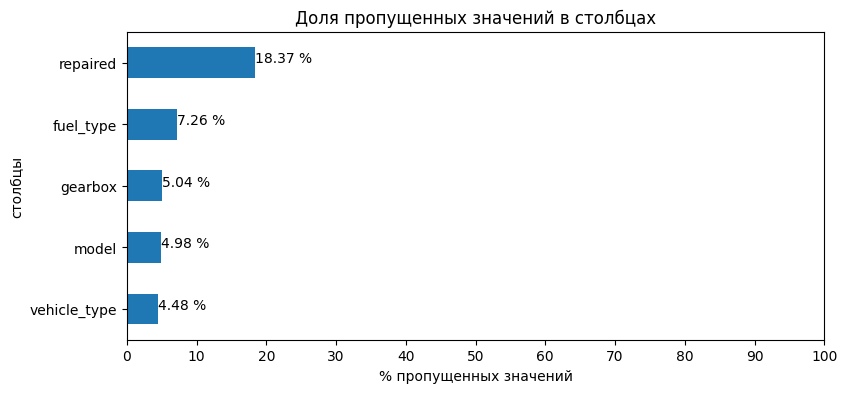

In [37]:
# визуализируем пропущенных значений в столбцах таблицы
plot_missing(data)

Пропущенные значения присутствуют только в категориальных признаках, имеющих текстовые значения. Заполним пропуски меткой-заполнителем `unknown`. Значение заполнителя выбрано таким образом, чтобы оно не совпадало с имеющимися значениями признаков.

In [38]:
# заполняем пропуски в данных
data = data.fillna('unknown')

#### Обработка аномалий

Чтобы получить хорошую точность предсказаний модели, её нужно обучать на качественных данных. Для адекватной оценки качества модели тоже требуются качественные тестовые данные. Поэтому нужно очистить исходные данные от аномалий и редких значений.

Рассмотрим статистические характеристики числовых признаков, в первую очередь минимальное и максимальное значения.

In [39]:
# статистические характеристики числовых признаков
data.describe().T.astype({'count': 'int'})

,count,mean,std,min,25%,50%,75%,max
price,331654,4531.574596,4563.723169,0.0,1100.0,2850.0,6500.0,20000.0
registration_year,331654,2002.151480,6.850934,1910.0,1999.0,2002.0,2007.0,2016.0
power,331654,111.745865,182.067919,0.0,70.0,105.0,143.0,20000.0
kilometer,331654,127919.171787,37954.182297,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,331654,5.773366,3.694324,0.0,3.0,6.0,9.0,12.0


В признаках `price`, `power` и `registration_month` присутствует аномальное значение `0`, которое, вероятно, является заменителем пропущенных значений. 

Записи с нулевыми значениями цены и мощности следует удалить, потому что они портят качество данных. Всё-таки это должны быть объявления о *продаже автомобилей*, а не дарении металлолома без двигателя.

В признаке `power` также аномально большое максимальное значение. С ним ещё разберёмся далее.

In [40]:
# удаляем записи с аномальными значениями признаков
data = data.query("price != 0 and power != 0")

Посчитаем количество оставшихся записей. Далее будем контролировать уровень потери при удалении редких значений, принимая это количество за исходное.

In [41]:
# количество записей в данных
num_records_in = len(data)

Рассмотрим повторно признак `registration_year` и посчитаем 1-процентиль распределения (0.01 квантиль).

In [42]:
# считаем квантили распределения
display(limit_year := data['registration_year'].quantile([0.01]))

0.01    1982.0
Name: registration_year, dtype: float64

Только 1% всех автомобилей в данных зарегистрированы ранее 1982 года, т.е. старше 34 лет на момент публикации объявления о продаже.

Аналогично посчитаем квантили для признаков `price` и `power`.

In [43]:
# считаем квантили распределения
display(limit_price := data['price'].quantile([0.01]))

0.01    150.0
Name: price, dtype: float64

Только 1% всех автомобилей в данных дешевле 150 евро.

In [44]:
# считаем квантили распределения
display(limits_power := data['power'].quantile([0.005, 0.995]))

0.005     40.0
0.995    340.0
Name: power, dtype: float64

Только 1% всех автомобилей в данных имеют мощность двигателя менее 40 л.с. или более 340 л.с.

Отфильтруем данные от редких значений признаков `registration_year`, `price` и `power`, используя рассчитанные значения квантилей. После этого подсчитаем количество оставшихся записей для контроля суммарного уровня потерь данных в результате фильтрации.

In [45]:
# удаляем записи с редкими значениями признаков
data = data.query(
    "registration_year >= @limit_year.values[0] "
    "and price >= @limit_price.values[0] "
    "and @limits_power.values[0] <= power <= @limits_power.values[1]"
)

# количество записей в данных
num_records_out = len(data)
print('Количество оставшихся записей:', num_records_out)
print('Доля потерь данных в результате фильтрации: '
      f'{(num_records_in - num_records_out) / num_records_in:.2%}')

Количество оставшихся записей: 284670
Доля потерь данных в результате фильтрации: 2.37%


Суммарный уровень потерь данных в результате фильтрации составил менее 3%, что вполне приемлемо. Выведем повторно статистические характеристики числовых признаков в отфильтрованных данных.

In [46]:
# статистические характеристики числовых признаков
data.describe().T.astype({'count': 'int'})

,count,mean,std,min,25%,50%,75%,max
price,284670,4882.657846,4581.993961,150.0,1399.0,3200.0,6999.0,20000.0
registration_year,284670,2002.910616,5.598055,1982.0,1999.0,2003.0,2007.0,2016.0
power,284670,120.628169,50.913698,40.0,80.0,114.0,150.0,340.0
kilometer,284670,128543.559209,36401.085162,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,284670,6.021759,3.569352,0.0,3.0,6.0,9.0,12.0


Для дополнительной проверки на наличие возможных аномалий в данных исследуем распределение количества записей по значениям признаков с помощью гистограмм.

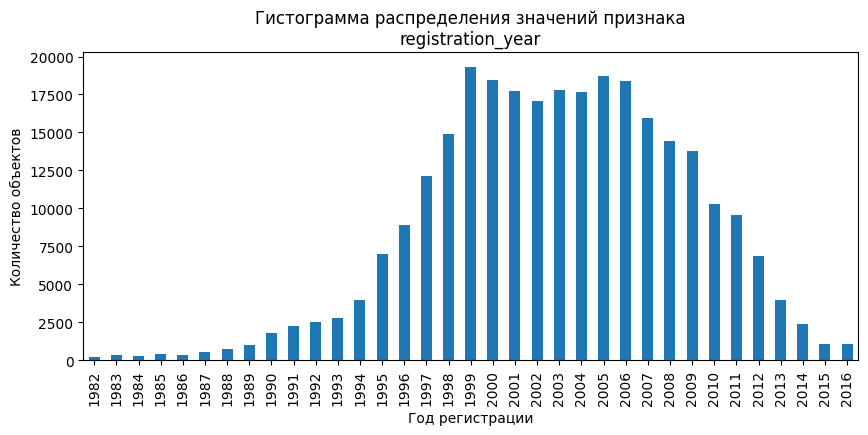

In [47]:
# строим гистограмму
cat_hist(data, 'registration_year')
plt.xlabel('Год регистрации');

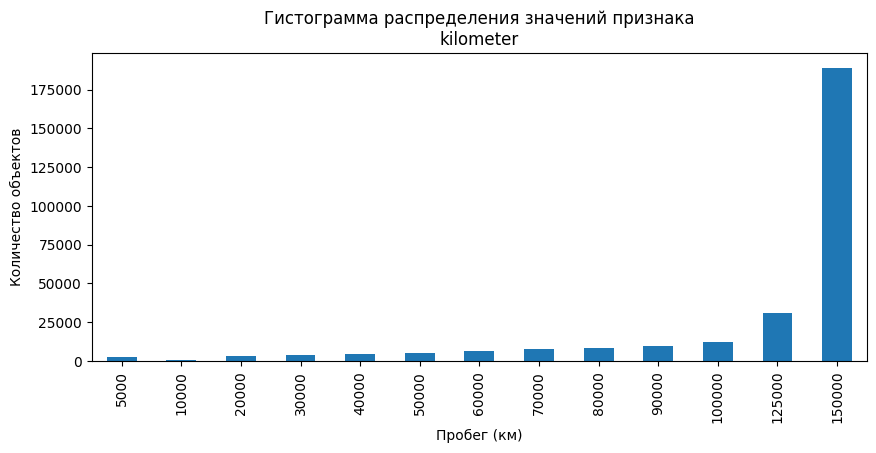

In [48]:
# строим гистограмму
cat_hist(data, 'kilometer')
plt.xlabel('Пробег (км)');

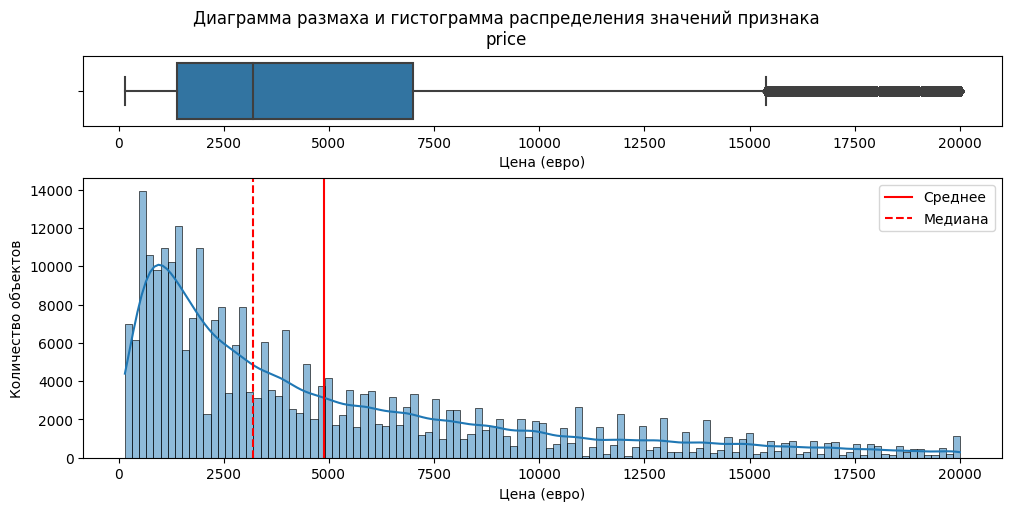

In [49]:
# строим гистограмму и диаграмму размаха
fig, axes = num_stat_plots(data, 'price')
for ax in axes:
    ax.set_xlabel('Цена (евро)')

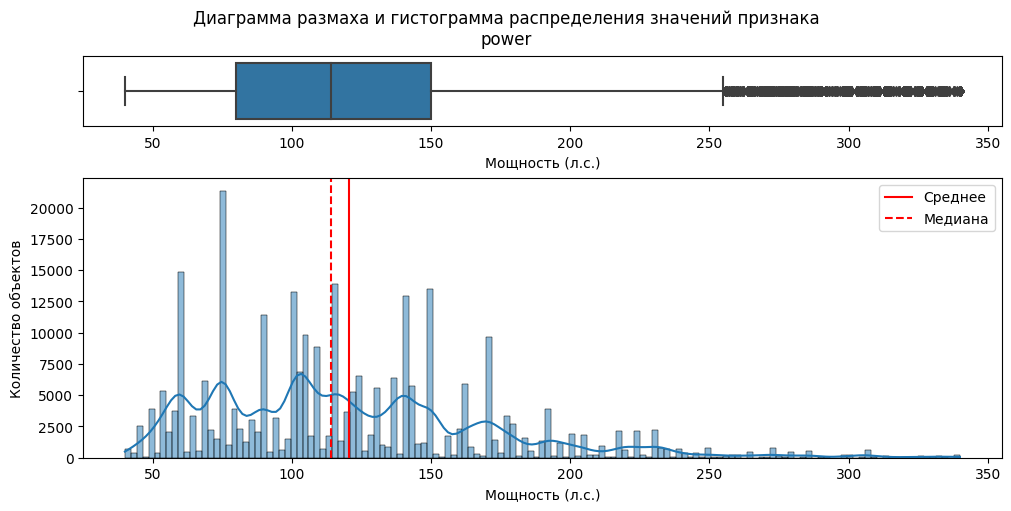

In [50]:
# строим гистограмму и диаграмму размаха
fig, axes = num_stat_plots(data, 'power')
for ax in axes:
    ax.set_xlabel('Мощность (л.с.)')

Дополнительные аномалии не обнаружены.

#### Добавление нового признака

Объединим признаки `registration_year` и `registration_month` в новый признак `registration_date` следующим образом:
- если $\text{registration\_month} \neq 0$, то $\text{registration\_date} = \text{registration\_year} + \frac{\text{registration\_month} - 1}{12}$,
- если $\text{registration\_month} = 0$, то $\text{registration\_date} = \text{registration\_year} + \frac{6.5}{12}$.

Таким образом, записи с отсутствующим месяцем регистрации, где `registration_month == 0`, будут приведены к середине соответствующего года.

Новый количественный признак `registration_date` более точно характеризует возраст автомобиля, чем исходный признак `registration_year`.

In [51]:
# определяем функцию для расчёта даты
def compose_date(row):
    year = row['registration_year']
    month = row['registration_month']
    
    if month != 0:
        return year + (month - 1) / 12
    else:
        return year + 6.5/12

# добавляем в данные новый признак
data['registration_date'] = data.apply(compose_date, axis=1)

Проверяем результат.

In [52]:
# выборка 20 случайных записей з данных
(data[['registration_year', 'registration_month', 'registration_date']]
 .sample(20, random_state=RANDOM_STATE)
)

,registration_year,registration_month,registration_date
339513,1999,1,1999.000000
16651,2000,2,2000.083333
83151,2002,7,2002.500000
336701,2010,0,2010.541667
120907,2013,6,2013.416667
144581,2004,5,2004.333333
205122,1996,6,1996.416667
284199,2002,1,2002.000000
307752,2010,4,2010.250000
24131,2006,3,2006.166667


После добавления нового признака `registration_date` исходные признаки `registration_year` и `registration_month` можно удалить.

In [53]:
# удаляем признаки
data = data.drop(columns=['registration_year', 'registration_month'])

#### Преобразование типа данных категориальных признаков

Приведём категориальные признаки к типу данных `category`, чтобы модель LightGBM могла работать с ними без предварительного кодирования.

In [54]:
# список категориальных признаков
cat_columns = data.columns[data.dtypes == 'object']

# преобразуем тип данных в 'category'
data[cat_columns] = data[cat_columns].astype('category')

Выведем информацию о данных после завершения их обработки.

In [55]:
# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284670 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              284670 non-null  int64   
 1   vehicle_type       284670 non-null  category
 2   gearbox            284670 non-null  category
 3   power              284670 non-null  int64   
 4   model              284670 non-null  category
 5   kilometer          284670 non-null  int64   
 6   fuel_type          284670 non-null  category
 7   brand              284670 non-null  category
 8   repaired           284670 non-null  category
 9   registration_date  284670 non-null  float64 
dtypes: category(6), float64(1), int64(3)
memory usage: 12.8 MB


### Разделение данных

Выделим из данных целевой признак `price` в отдельную переменную и разделим данные на тренировочную и тестовую выборки.

In [56]:
# входные признаки
X = data.drop(columns='price')
# целевой признак
y = data['price']

# разделяем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
)

print('Размер обучающей выборки:', X_train.shape[0])
print('Размер тестовой выборки:', X_test.shape[0])
print('Количество входных признаков:', X_train.shape[1])

Размер обучающей выборки: 213502
Размер тестовой выборки: 71168
Количество входных признаков: 9


После выделения выборок для обучения и проверки качества моделей исходный датасет больше не понадобится, и его можно удалить.

In [57]:
# удаляем переменную, которая больше не понадобится
del data

### Анализ корреляций

Исследуем степень связи входных признаков, в том числе категориальных, друг с другом и c целевым признаком. Для этого рассчитаем матрицу корреляций $\phi_k$  и визуализируем её в виде тепловой карты. Для этого используем функцию `corr_matrix`, в которой реализован метод `phik_matrix` из библиотеки `phik`.

Матрицу корреляций построим отдельно для тренировочной и тестовой выборки, чтобы убедиться в том, что связи между признаками в них близки.

При использовании `phik_matrix` нужно передать ему в аргументе `interval_cols`  список с названиями непрерывных количественных признаков, т.к. от типа признака зависит метод оценки корреляции. В анализируемых данных такими признаками являются `price`, `power` и `registration_date`. 

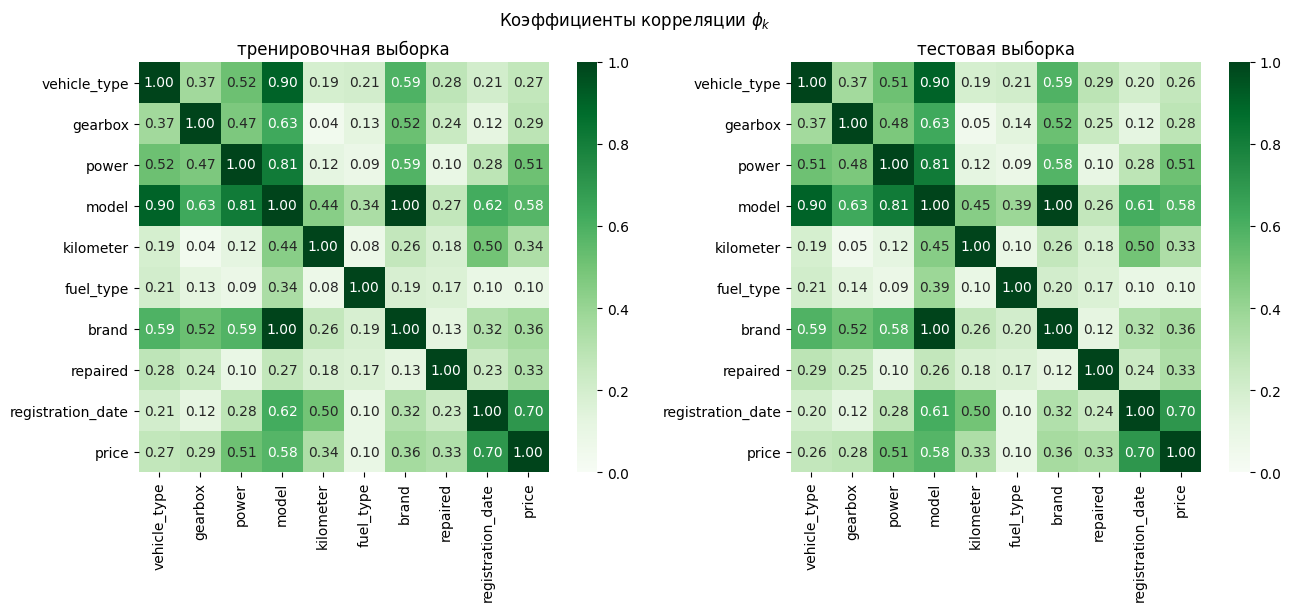

In [58]:
# список непрерывных количественных признаков
interval_cols = ['price', 'power', 'registration_date']

# создаём область построения графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), constrained_layout=True)

plt.sca(axes[0])
# строим матрицу корреляции
# для тренировочной выборки
corr_matrix(X_train.join(y_train), method='phik', interval_cols=interval_cols)
title = axes[0].get_title()
axes[0].set_title('тренировочная выборка')

plt.sca(axes[1])
# строим матрицу корреляции
# для тестовой выборки
corr_matrix(X_test.join(y_test), method='phik', interval_cols=interval_cols)
axes[1].set_title('тестовая выборка')

fig.suptitle(title);

**Выводы:**
- Различие в величине корреляции между признаками в тренировочной и тестовой выборках не превышают 0.02, за исключением пары признаков `model` и `fuel_type`, для которых разница составляет 0.05.
- Признаки `model` и `brand`, а также `model` и `vehicle_type`, сильно коррелированы. Это означает наличие мультиколлинеарности входных признаков, которая представляет серьёзную проблему для линейных моделей.

### Кодирование категориальных признаков

Посмотрим на распределение входных признаков по их типу: количественные или категориальные.

In [59]:
print('Всего в данных {} входных признаков, из них {} количественных: {}\nи {} категориальных: {}'
      .format(len(X.columns),
              len(X.columns) - len(cat_columns),
              X.columns.drop(cat_columns).tolist(),
              len(cat_columns),
              cat_columns.tolist()
             ),
     )

Всего в данных 9 входных признаков, из них 3 количественных: ['power', 'kilometer', 'registration_date']
и 6 категориальных: ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']


Когда в данных больше категориальных признаков, чем количественных, лучше использовать модели, основанные на деревьях решений. Деревья решений не требуют предварительного масштабирования количественных входных признаков, поскольку правила разбиения в узлах дерева не изменятся при применении к данным монотонного преобразования.

Однако для моделей дерева решений и случайного леса из библиотеки skikit-learn требуется предварительное кодирование категориальных признаков. К счастью, для деревьев решений не требуется использовать OHE-кодирование, которое при наличии большого количества уникальных значений признака приводит к появлению в данных очень большого количества новых признаков с разреженными значениями. Более чем достаточно будет применить порядковое кодирование с помощью `OrdinalEncoder`.

И поскольку далее предполагается поиск оптимальных гиперпараметров, то чтобы сэкономить вычислительные ресурсы, лучше выполнить кодирование один раз заранее, чем добавлять кодировщик в пайплайны моделей.

Кодирование категориальных признаков реализовано в пользовательской функции `encode_features`.

In [60]:
# инициализируем кодировщик
encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1,
)

# кодируем категориальные признаки
X_train_encoded, X_test_encoded = encode_features(
    encoder, cat_columns, X_train, X_test)

При оценке производительности моделей, требующих кодирования категориальных признаков, нужно учитывать и время, затрачиваемое на кодирование. Для этого подготовим трансформер, который нужно будет включить в пайплайн модели при измерении её времени обучения и предсказания.

In [61]:
# создаём трансформер
transformer = ColumnTransformer(
    [('categorical', clone(encoder), cat_columns)], 
    remainder='passthrough',
    verbose_feature_names_out=False,
)
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], dtype='object'))],
                  verbose_feature_names_out=False)

### Выводы

Исходные данные загружены, обработаны и подготовлены к использования для обучения и оценки качества моделей.

- Выполнена предобработка данных:
    - Названия признаков приведены в соответствие с форматом "snake_case".
    - Удалены полные дубликаты записей.
    - Удалены неинформативные признаки, которые не могут влиять не целевой — цену автомобиля: дата скачивания анкеты из базы, дата создания анкеты, количество фотографий автомобиля, почтовый индекс пользователя, дата последней активности пользователя.
    - Заполнены пропущенные значения, присутствовавшие в категориальных признаках, значением-заполнителем `unknown`.
    - В признаке `fuel_type` устранены неявные дубликаты значений: `gasoline` и `petrol`. И то, и другое — это бензин.
    - Данные очищены от обнаруженных аномальных значений признаков `price` и `power` (значение `0`) и признака `registration_year` (нереальные значения в прошлом и будущем), а также отфильтрованы от редких значений этих признаков. Суммарный уровень потерь данных в результате фильтрации составил менее 3% от количества записей после удаления аномалий, что вполне приемлемо.
    - Признаки `registration_year` и `registration_month` объединены в новый признак `registration_date` — год регистрации с добавлением доли года, соответствующей месяцу регистрации. Записи с отсутствующим месяцем регистрации (`registration_month == 0`) приведены к середине соответствующего года. Новый количественный признак `registration_date` более точно характеризует возраст автомобиля.
    - Категориальные текстовые признаки в данных приведены к типу данных `category`, чтобы модель LightGBM могла работать с ними без предварительного кодирования.

- Данные разделены на на тренировочную и тестовую выборки с выделением целевого признака `price` в отдельную переменную.

- Исследована связь входных признаков, в том числе категориальных, друг с другом и c целевым признаком, с помощью матрицы корреляций $\phi_k$. 
    - Установлено, что различия в величине корреляции между признаками в тренировочной и тестовой выборках незначительны.
    - Обнаружена сильная парная корреляция между некоторыми признаками, что означает наличие мультиколлинеарности входных признаков. Это представляет серьёзную проблему для линейных моделей.

- Выполнено предварительное кодирование категориальных входных признаков в данных с помощью `OrdinalEncoder` для работы с моделями дерева решений и случайного леса из библиотеки skikit-learn. Модели LightGBM и CatBoost могут работать с исходными данными без кодирования. Также подготовлен трансформер для включения в пайплайн моделей, требующих кодирования категориальных признаков, при измерении времени обучения и предсказания.

## Обучение моделей

Как уже было отмечено, в ситуации преобладания в данных категориальных признаков лучше использовать модели, основанные на деревьях решений. Поэтому выберем для обучения следующие модели:
- простое (одиночное) дерево решений: класс `DecisionTreeRegressor` из библиотеки skikit-learn;
- случайный лес: класс `RandomForestRegressor` из библиотеки skikit-learn;

а также модели градиентного бустинга на деревьях решений:
- LightGBM: класс `LGBMRegressor`;
- CatBoost: класс `CatBoostRegressor`.

### DecisionTreeRegressor

In [62]:
# инициализируем модель
single_tree = DecisionTreeRegressor(
    criterion='squared_error',
    random_state=RANDOM_STATE
)

Найдём глубину обученного дерева, если не задано ограничение.

In [63]:
# обучаем модель на тренировочной выборке
%time single_tree.fit(X_train_encoded, y_train)

# находим глубину дерева решений
single_tree_max_depth = single_tree.get_depth()
print('Глубина дерева решений, если не задано ограничение: '
      f'{single_tree_max_depth = }')

CPU times: user 5.63 s, sys: 45.6 ms, total: 5.68 s
Wall time: 5.77 s
Глубина дерева решений, если не задано ограничение: single_tree_max_depth = 50


Оценим качество модели, рассчитав метрику RMSE с помощью кросс-валидации по 5 блокам на тренировочной выборке. Пользовательская функция `cross_val_rmse` вызывает функцию `cross_val_score` из модуля `sklearn.model_selection` с соответствующими аргументами и возвращает среднее значение метрики.

In [64]:
%%time
# вычисляем метрику модели на тренировочной выборке при кросс-валидации
cv_score_single_tree = cross_val_rmse(single_tree, X_train_encoded, y_train)
print('Метрика RMSE модели на тренировочной выборке при кросс-валидации: '
      f'{cv_score_single_tree:.2f}')

Метрика RMSE модели на тренировочной выборке при кросс-валидации: 1956.99
CPU times: user 22.1 s, sys: 18.5 ms, total: 22.1 s
Wall time: 22.1 s


Подберём значения гиперпараметров модели, которые помогут повысить её качество (т.е. получить меньшее значение метрики RMSE). У модели дерева решений несколько гиперпараметров, определяющих его структуру. Среди них основные:
- `max_depth` — максимальная глубина дерева (по умолчанию не ограничена);
- `min_samples_leaf` — минимальное количество объектов в листе (по умолчанию 1).

Подбор оптимальной комбинации гиперпараметров методом полного перебора с использованием `GridSearchCV` занял бы много времени, а при случайном поиске с использованием `RandomizedSearchCV` есть риск пропустить хорошую комбинацию. Поэтому используем поиск с помощью метода байесовской оптимизации, реализованный в `OptunaSearchCV`.

Чтобы не повторять заново поиск оптимальных значений гиперпараметров при каждом перезапуске ядра (ipykernel), найденные значения зафиксированы в коде. Выбор режима (выполнять поиск заново или нет) осуществляется с помощью задания константы `SKIP_HYPERPARAMETER_SEARCH` в разделе "Настройки".

In [65]:
if not SKIP_HYPERPARAMETER_SEARCH:
    # словарь со списками параметров для перебора
    parameters = {
        'max_depth': distributions.IntDistribution(1, single_tree_max_depth),
        'min_samples_leaf': distributions.IntDistribution(1, 50),
    }
    # инициализируем класс для автоматизированного подбора параметров
    optuna_search = OptunaSearchCV(
        single_tree,
        parameters,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_trials=30,
        random_state=RANDOM_STATE,
    )
    # запускаем подбор параметров 
    %time optuna_search.fit(X_train_encoded, y_train)
    
    # лучшие параметры модели
    single_tree_best_params = optuna_search.best_params_
    # лучшая модель
    single_tree = optuna_search.best_estimator_
    # метрика лучшей модели на тренировочной выборке при кросс-валидации
    cv_score_single_tree = -optuna_search.best_score_

else:
    # лучшие параметры модели
    single_tree_best_params = {
        'max_depth': 36, 
        'min_samples_leaf': 11, 
    }
    # лучшая модель
    single_tree = single_tree.set_params(**single_tree_best_params)
    # обучаем модель на тренировочной выборке
    single_tree.fit(X_train_encoded, y_train)
    # метрика лучшей модели на тренировочной выборке при кросс-валидации
    %time cv_score_single_tree = cross_val_rmse(single_tree, X_train_encoded, y_train)

print('Лучшая модель:')
display(single_tree)

print('Метрика RMSE лучшей модели на тренировочной выборке при кросс-валидации: '
      f'{cv_score_single_tree:.2f}')

CPU times: user 15.2 s, sys: 33.3 ms, total: 15.2 s
Wall time: 15.2 s
Лучшая модель:


DecisionTreeRegressor(max_depth=36, min_samples_leaf=11, random_state=42)

Метрика RMSE лучшей модели на тренировочной выборке при кросс-валидации: 1697.48


Оценим производительность модели, для этого измерим:
- время обучения модели на тренировочной выборке;
- время предсказания модели для одной случайно выбранной записи из тестовой выборки, поскольку при применении модели в реальных условиях работы новые записи для получения предсказаний будут поступать по одной.

Измерение времени обучения и предсказания модели реализовано в пользовательской функции `timing()`.

Для учёта времени, затрачиваемого на кодирование категориальных признаков, включим в пайплайн модели заранее подготовленный для этого трансформер.

In [66]:
# создаём пайплайн
single_tree_pipe = make_pipeline(transformer, single_tree)
single_tree_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=36, min_samples_leaf=11,
                                       random_state=42))])

In [67]:
# измеряем время обучения и предсказания модели
train_time_single_tree, pred_time_single_tree = timing(single_tree_pipe)

Время обучения модели:
 4.8 s ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Время предсказания модели:
 24 ms ± 72.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### RandomForestRegressor

In [68]:
# инициализируем модель
random_forest = RandomForestRegressor(
    criterion='squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

Найдём максимальную глубину дерева в лесе, если не задано ограничение.

In [69]:
# обучаем модель на тренировочной выборке
%time random_forest.fit(X_train_encoded, y_train)

# находим максимальную глубину дерева решений
random_forest_max_depth = max([t.get_depth() for t in random_forest.estimators_])
print('Максимальная глубина дерева решений, если не задано ограничение: '
      f'{random_forest_max_depth = }')

CPU times: user 6min 59s, sys: 2.37 s, total: 7min 1s
Wall time: 1min 49s
Максимальная глубина дерева решений, если не задано ограничение: random_forest_max_depth = 52


Оценим качество модели, рассчитав среднее значение метрики RMSE при кросс-валидации по 5 блокам на тренировочной выборке.

In [70]:
%%time 
# вычисляем метрику модели на тренировочной выборке при кросс-валидации
cv_score_random_forest = cross_val_rmse(random_forest, X_train_encoded, y_train)
print('Метрика RMSE модели на тренировочной выборке при кросс-валидации: '
      f'{cv_score_random_forest:.2f}')

Метрика RMSE модели на тренировочной выборке при кросс-валидации: 1523.80
CPU times: user 29min 49s, sys: 10.1 s, total: 29min 59s
Wall time: 7min 44s


Подберём оптимальные значения гиперпараметров модели. Помимо гиперпараметров, ограничивающих рост отдельного дерева, у модели случайного леса есть важная настройка `max_features` — количество используемых признаков, выбираемых случайным образом для каждого дерева (по умолчанию используются все признаки, в таком случае модель эквивалентна бэггингу над решающими деревьями).

Подбор оптимальной комбинации гиперпараметров также выполним с помощью `OptunaSearchCV`.

In [71]:
if not SKIP_HYPERPARAMETER_SEARCH:
    # словарь со списками параметров для перебора
    parameters = {
        'max_depth': distributions.IntDistribution(1, random_forest_max_depth),
        'min_samples_leaf': distributions.IntDistribution(1, 50),
        'max_features': distributions.IntDistribution(3, X.shape[1]),
    }
    # инициализируем класс для автоматизированного подбора параметров
    optuna_search = OptunaSearchCV(
        random_forest,
        parameters,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_trials=30,
        random_state=RANDOM_STATE,
    )
    # запускаем подбор параметров 
    %time optuna_search.fit(X_train_encoded, y_train)

    # лучшие параметры модели
    random_forest_best_params = optuna_search.best_params_
    # лучшая модель
    random_forest = optuna_search.best_estimator_
    # метрика лучшей модели на тренировочной выборке при кросс-валидации
    cv_score_random_forest = -optuna_search.best_score_

else:
    # лучшие параметры модели
    random_forest_best_params = {
        'max_depth': 47, 
        'min_samples_leaf': 3, 
        'max_features': 5,
    }
    # лучшая модель
    random_forest = random_forest.set_params(**random_forest_best_params)
    # обучаем модель на тренировочной выборке
    random_forest.fit(X_train_encoded, y_train)
    # метрика лучшей модели на тренировочной выборке при кросс-валидации
    %time cv_score_random_forest = cross_val_rmse(random_forest, X_train_encoded, y_train)

print('Лучшая модель:')
display(random_forest)

print('Метрика RMSE лучшей модели на тренировочной выборке при кросс-валидации: '
      f'{cv_score_random_forest:.2f}')

CPU times: user 13min 47s, sys: 3.25 s, total: 13min 50s
Wall time: 3min 33s
Лучшая модель:


RandomForestRegressor(max_depth=47, max_features=5, min_samples_leaf=3,
                      n_jobs=-1, random_state=42)

Метрика RMSE лучшей модели на тренировочной выборке при кросс-валидации: 1485.33


Измерим время обучения и предсказания модели реализовано с помощью функции `timing()`.

Для учёта времени, затрачиваемого на кодирование категориальных признаков, включим в пайплайн модели заранее подготовленный для этого трансформер.

In [72]:
# создаём пайплайн
random_forest_pipe = make_pipeline(transformer, random_forest)
random_forest_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=47, max_features=5,
                                       min_samples_leaf=3, n_jobs=-1,
                                       random_state=42))])

In [73]:
# измеряем время обучения и предсказания модели
train_time_random_forest, pred_time_random_forest = timing(random_forest_pipe)

Время обучения модели:
 52.3 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Время предсказания модели:
 94.2 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### LGBMRegressor

В отличие от рассмотренных выше моделей, LightGBM может работать с категориальными текстовыми признаками, имеющими тип данных `category`, без предварительного кодирования. Но для этого при обучении модели нужно передать ей список категориальных признаков с помощью параметра `categorical_feature`.

In [74]:
# инициализируем модель
lightgbm = LGBMRegressor( 
    objective='rmse',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1,
)
# параметры обучения модели
lightgbm_fit_params = {
    # список категориальных признаков
    'categorical_feature': cat_columns.tolist(),
}

Создадим копию модели с настройками по умолчанию, чтобы впоследствии сравнить её качество и производительность с моделью, оптимизированной путём подбора гиперпараметров для получения максимального качества предсказаний (т.е. минимального значения метрики RMSE).

In [75]:
# создаём копию модели
lightgbm_default = clone(lightgbm)

Оценим качество модели, рассчитав среднее значение метрики RMSE при кросс-валидации по 5 блокам на тренировочной выборке.

In [76]:
%%time
# вычисляем метрику модели на тренировочной выборке при кросс-валидации
cv_score_lightgbm_default = cross_val_rmse(lightgbm_default, X_train, y_train, params=lightgbm_fit_params)
print('Метрика RMSE модели на тренировочной выборке при кросс-валидации: '
      f'{cv_score_lightgbm_default:.2f}')

Метрика RMSE модели на тренировочной выборке при кросс-валидации: 1523.66
CPU times: user 50.5 s, sys: 176 ms, total: 50.6 s
Wall time: 14.5 s


Измерим время обучения и предсказания модели с настройками по умолчанию.

In [77]:
# измеряем время обучения и предсказания модели
train_time_lightgbm_default, pred_time_lightgbm_default = timing(lightgbm_default, **lightgbm_fit_params)

Время обучения модели:
 2.81 s ± 8.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Время предсказания модели:
 32 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Подберём оптимальные значения гиперпараметров модели, ограничивающих рост отдельного дерева в ансамбле. У модели LightGBM  основные настройки для этого:
- `min_data_in_leaf` — минимальное количество объектов в одном листе дерева (по умолчанию 20);
- `num_leaves` — максимальное количество листов в одном дереве (по умолчанию 31).

Подбор оптимальной комбинации гиперпараметров также выполним с помощью `OptunaSearchCV`.

In [78]:
if not SKIP_HYPERPARAMETER_SEARCH:
    # словарь со списками параметров для перебора
    parameters = {
        'min_data_in_leaf': distributions.IntDistribution(1, 100),
        'num_leaves': distributions.IntDistribution(15, 1023, log=True),
    }
    # инициализируем класс для автоматизированного подбора параметров
    optuna_search = OptunaSearchCV(
        lightgbm,
        parameters,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_trials=40,
        random_state=RANDOM_STATE,
    )
    # запускаем подбор параметров 
    %time optuna_search.fit(X_train, y_train, **lightgbm_fit_params)

    # лучшие параметры модели
    lightgbm_best_params = optuna_search.best_params_
    # лучшая модель
    lightgbm = optuna_search.best_estimator_
    # метрика лучшей модели на тренировочной выборке при кросс-валидации
    cv_score_lightgbm = -optuna_search.best_score_

else:
    # лучшие параметры модели
    lightgbm_best_params = {
        'min_data_in_leaf': 6,
        'num_leaves': 664, 
    }
    # лучшая модель
    lightgbm = lightgbm.set_params(**lightgbm_best_params)
    # обучаем модель на тренировочной выборке
    lightgbm.fit(X_train, y_train, **lightgbm_fit_params)
    # метрика лучшей модели на тренировочной выборке при кросс-валидации
    %time cv_score_lightgbm = cross_val_rmse(lightgbm, X_train, y_train, params=lightgbm_fit_params)

print('Лучшая модель:')
display(lightgbm)

print('Метрика RMSE лучшей модели на тренировочной выборке при кросс-валидации: '
      f'{cv_score_lightgbm:.2f}')

CPU times: user 3min 8s, sys: 2.68 s, total: 3min 11s
Wall time: 50 s
Лучшая модель:


LGBMRegressor(min_data_in_leaf=6, n_jobs=-1, num_leaves=664, objective='rmse',
              random_state=42, verbose=-1)

Метрика RMSE лучшей модели на тренировочной выборке при кросс-валидации: 1420.68


Измерим время обучения и предсказания модели с оптимизированными значениями гиперпараметров.

In [79]:
# измеряем время обучения и предсказания модели
train_time_lightgbm, pred_time_lightgbm = timing(lightgbm, **lightgbm_fit_params)

Время обучения модели:
 10 s ± 43.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Время предсказания модели:
 32 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### CatBoostRegressor

Аналогично LightGBM, модель CatBoost может работать с категориальными текстовыми признаками без предварительного кодирования. Для этого при обучении модели нужно передать ей список категориальных признаков с помощью параметра `cat_features`.

По умолчанию в CatBoost задано число итераций алгоритма градиентного бустинга, равное 1000 (параметр `iterations`). Из-за этого модель обучается слишком долго. Поэтому уменьшим количество итераций до 100, задав это значение в начальных параметрах модели. Это можно сделать при инициализации, но чтобы контролировать, какие параметры модели отличаются от настроек по умолчанию, лучше сделать это отдельно.

In [80]:
# инициализируем модель
catboost = CatBoostRegressor(
    loss_function='RMSE',
    random_state=RANDOM_STATE,
    thread_count=-1,
    verbose=False,
)

# начальные параметры модели
catboost_init_params = {
    'iterations': 100,
}
catboost.set_params(**catboost_init_params)

# параметры обучения модели
catboost_fit_params = {
    # список категориальных признаков
    'cat_features': cat_columns.tolist(),
}

Создадим копию модели с настройками по умолчанию, чтобы впоследствии сравнить её качество и производительность с моделью, оптимизированной путём подбора гиперпараметров.

In [81]:
# создаём копию модели
catboost_default = clone(catboost)

Оценим качество модели, рассчитав среднее значение метрики RMSE при кросс-валидации по 5 блокам на тренировочной выборке.

In [82]:
%%time
# вычисляем метрику модели на тренировочной выборке при кросс-валидации
cv_score_catboost_default = cross_val_rmse(catboost_default, X_train, y_train, params=catboost_fit_params)
print('Метрика RMSE модели на тренировочной выборке при кросс-валидации: '
      f'{cv_score_catboost_default:.2f}')

Метрика RMSE модели на тренировочной выборке при кросс-валидации: 1585.78
CPU times: user 3min 24s, sys: 8.26 s, total: 3min 32s
Wall time: 57.8 s


Измерим время обучения и предсказания модели с настройками по умолчанию.

In [83]:
# измеряем время обучения и предсказания модели
train_time_catboost_default, pred_time_catboost_default = timing(catboost_default, **catboost_fit_params)

Время обучения модели:
 14.2 s ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Время предсказания модели:
 14.6 ms ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Подберём оптимальные значения гиперпараметров модели:
- `learning_rate` — скорость обучения, регулирующая размер шага в алгоритме градиентного бустинга;
- `max_depth` — глубина отдельного дерева в ансамбле (по умолчанию 6).

Подбор оптимальной комбинации гиперпараметров также выполним с помощью `OptunaSearchCV`.

In [84]:
if not SKIP_HYPERPARAMETER_SEARCH:
    # словарь со списками параметров для перебора
    parameters = {
        'learning_rate': distributions.FloatDistribution(0.1, 1.0, step=0.1),
        'max_depth': distributions.IntDistribution(2, 10),       
    }
    # инициализируем класс для автоматизированного подбора параметров
    optuna_search = OptunaSearchCV(
        catboost,
        parameters,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_trials=10,
        random_state=RANDOM_STATE,
        verbose=-1
    )
    # запускаем подбор параметров 
    %time optuna_search.fit(X_train, y_train, **catboost_fit_params)

    # лучшие параметры модели
    catboost_best_params = optuna_search.best_params_
    # лучшая модель
    catboost = optuna_search.best_estimator_
    # метрика лучшей модели на тренировочной выборке при кросс-валидации
    cv_score_catboost = -optuna_search.best_score_

else:
    # лучшие параметры модели
    catboost_best_params = {
        'learning_rate': 0.5,
        'max_depth': 10, 
    }
    # лучшая модель
    catboost = catboost.set_params(**catboost_best_params)
    # обучаем модель на тренировочной выборке
    catboost.fit(X_train, y_train, **catboost_fit_params)
    # метрика лучшей модели на тренировочной выборке при кросс-валидации
    %time cv_score_catboost = cross_val_rmse(catboost, X_train, y_train, params=catboost_fit_params)

print('Параметры лучшей модели:')
print(catboost.get_params())

print('Метрика RMSE лучшей модели на тренировочной выборке при кросс-валидации: '
      f'{cv_score_catboost:.2f}')

CPU times: user 6min 4s, sys: 13.5 s, total: 6min 18s
Wall time: 1min 42s
Параметры лучшей модели:
{'loss_function': 'RMSE', 'verbose': False, 'random_state': 42, 'iterations': 100, 'learning_rate': 0.5, 'max_depth': 10}
Метрика RMSE лучшей модели на тренировочной выборке при кросс-валидации: 1513.20


Измерим время обучения и предсказания модели с оптимизированными значениями гиперпараметров.

In [85]:
# измеряем время обучения и предсказания модели
train_time_catboost, pred_time_catboost = timing(catboost, **catboost_fit_params)

Время обучения модели:
 24.9 s ± 359 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Время предсказания модели:
 14.6 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Выводы

1. Рассмотрены модели 4 классов:
    - одиночное дерево решений `DecisionTreeRegressor`;
    - случайный лес `RandomForestRegressor`;
    - градиентный бустинг на деревьях решений из библиотеки LightGBM: `LGBMRegressor`;
    - градиентный бустинг на деревьях решений из библиотеки CatBoost: `CatBoostRegressor`.

2. Для всех типов моделей подобраны оптимальные значения некоторых гиперпараметров, обеспечивающие минимальное среднее значение метрики RMSE при кросс-валидации на тренировочной выборке.

3. В результате получены 6 моделей:
    - `DecisionTreeRegressor` с оптимизированными значениями гиперпараметров `max_depth`и `min_samples_leaf`;
    - `RandomForestRegressor` с оптимизированными значениями гиперпараметров `max_depth`, `min_samples_leaf` и `max_features`;
    - `LGBMRegressor` с настройками по умолчанию,
    - `LGBMRegressor` с оптимизированными значениями гиперпараметров `min_data_in_leaf`и `num_leaves`,
    - `CatBoostRegressor` с гиперпараметром `iterations = 100` и остальными настройками по умолчанию,
    - `CatBoostRegressor` с гиперпараметром `iterations = 100` и оптимизированными значениями гиперпараметров `learning_rate` и `max_depth`.

4. Для каждой модели получены значения характеристик для сравнения:
    - среднее значение метрики RMSE при кросс-валидации на тренировочной выборке;
    - среднее время обучения на тренировочной выборке;
    - среднее время предсказания для одной случайно выбранной записи из тестовой выборки.

## Анализ моделей

### Выбор лучшей модели

Чтобы сравнить между собой полученные модели, сведём их характеристики в итоговую таблицу. В таблице будут следующие поля:
- `model` — название модели;
- `nondefault_parameters` — значения гиперпараметров, отличающиеся от значений по умолчанию для данного класса модели;
- `cv_rmse` — среднее значение метрики RMSE при кросс-валидации на тренировочной выборке;
- `train_time_s` — среднее время обучения на тренировочной выборке (в секундах);
- `predict_time_ms` — среднее время предсказания для одной случайно выбранной записи из тестовой выборки (в миллисекундах).

In [86]:
# названия моделей
model_names = [
    'DecisionTreeRegressor', 
    'RandomForestRegressor', 
    'LGBMRegressor_default',
    'LGBMRegressor', 
    'CatBoostRegressor_default',
    'CatBoostRegressor',
]

# характеристики моделей
columns = [
    'model',
    'nondefault_parameters',
    'cv_rmse', 
    'train_time_s', 
    'predict_time_ms',
]

# формируем таблицу
results = pd.DataFrame(
    [
        [
            'DecisionTreeRegressor',
            str(single_tree_best_params),
            cv_score_single_tree,
            train_time_single_tree,
            pred_time_single_tree     
        ],
        [
            'RandomForestRegressor',
            str(random_forest_best_params),
            cv_score_random_forest,
            train_time_random_forest,
            pred_time_random_forest    
        ],
        [
            'LGBMRegressor_default',
            str(None),
            cv_score_lightgbm_default,
            train_time_lightgbm_default,
            pred_time_lightgbm_default   
        ],
        [
            'LGBMRegressor',
            str(lightgbm_best_params),
            cv_score_lightgbm,
            train_time_lightgbm,
            pred_time_lightgbm    
        ],
        [
            'CatBoostRegressor_default',
            str(catboost_init_params),
            cv_score_catboost_default,
            train_time_catboost_default,
            pred_time_catboost_default    
        ],
        [
            'CatBoostRegressor',
            str(catboost_init_params | catboost_best_params),
            cv_score_catboost,
            train_time_catboost,
            pred_time_catboost    
        ]
    ],
    index=model_names, 
    columns=columns
).set_index('model')

results['predict_time_ms'] *= 1000

In [87]:
# выводим таблицу
(results
 .sort_values(by='cv_rmse')
 .style
 .format({
     'cv_rmse': '{:.0f}',
     'train_time_s': '{:.2f}',
     'predict_time_ms': '{:.1f}',
 })
 .highlight_min(color='lightgreen') 
 .highlight_max(color='pink')
)

,nondefault_parameters,cv_rmse,train_time_s,predict_time_ms
model,,,,
LGBMRegressor,"{'min_data_in_leaf': 6, 'num_leaves': 664}",1421,10.04,32.0
RandomForestRegressor,"{'max_depth': 47, 'min_samples_leaf': 3, 'max_features': 5}",1485,52.29,94.2
CatBoostRegressor,"{'iterations': 100, 'learning_rate': 0.5, 'max_depth': 10}",1513,24.88,14.6
LGBMRegressor_default,None,1524,2.81,32.0
CatBoostRegressor_default,{'iterations': 100},1586,14.16,14.6
DecisionTreeRegressor,"{'max_depth': 36, 'min_samples_leaf': 11}",1697,4.80,24.0


Лучшее качество (т.е. минимальное значение метрики RMSE) показала оптимизированная модель градиентного бустинга LightGBM `LGBMRegressor`. При этом время обучения модели не слишком велико, но и время предсказания не самое маленькое.

Оптимизированная модель случайного леса `RandomForestRegressor` показала второй результат по качеству, но очень долго обучается и делает предсказания. Причина этого в устройстве модели: она состоит из 100 деревьев решений, каждое из которых нужно обучить, а при предсказании получить результат от всех деревьев и усреднить.

Оптимизированная модель градиентного бустинга CatBoost `CatBoostRegressor` показала качество чуть хуже, чем у модели `RandomForestRegressor`, но при этом быстрее обучается и делает предсказания. По скорости предсказания CatBoost превосходит другие модели: её время предсказания минимально.

Наименьшее время обучения у модели LightGBM с настройками по умолчанию `LGBMRegressor_default`, при этом качество модели вполне приличное — лучше, чем у модели CatBoost с таким же количеством итераций градиентного бустинга и тем более лучше, чем у оптимизированного дерева решений `DecisionTreeRegressor`.

Простая модель дерева решений `DecisionTreeRegressor` обучается быстрее всего, но качество её предсказаний ниже, чем у более сложных моделей.

**Вывод:**

Для заказчика важны все три характеристики: качество предсказания, время обучения модели, время предсказания модели. Но их приоритет при выборе лучшей модели не обозначен. В принципе, все рассмотренные модели отвечают заданному требованию RMSE < 2500. Поэтому в зависимости от желаемого баланса между характеристиками возможны разные решения:
- Если в приоритете **качество модели**, то следует выбрать оптимизированную модель LightGBM `LGBMRegressor`.
- Если в приоритете **время обучения модели** и можно пожертвовать качеством предсказаний, то следует выбрать модель LightGBM с настройками по умолчанию `LGBMRegressor_default`. 
- Если же в приоритете **время предсказания** и можно пожертвовать качеством предсказаний и скоростью обучения, то следует выбрать оптимизированную модель CatBoost `CatBoostRegressor`.

По совокупности характеристик следует выбрать оптимизированную модель LightGBM `LGBMRegressor` как модель, которая обеспечивает наилучшее качество предсказаний и при этом приемлемые и сбалансированные значения времени обучения и предсказания.

In [88]:
# лучшая модель
best_model = lightgbm

# параметры обучения модели
fit_params = lightgbm_fit_params

best_model

LGBMRegressor(min_data_in_leaf=6, n_jobs=-1, num_leaves=664, objective='rmse',
              random_state=42, verbose=-1)

### Анализ лучшей модели

#### Проверка качества модели

Получим предсказания лучшей модели и рассчитаем значение метрики RMSE на тестовой выборке.

In [89]:
# делаем предсказания на тестовой выборке
y_pred_best = best_model.predict(X_test)

# считаем метрику на тестовой выборке
best_model_test_score = root_mean_squared_error(y_test, y_pred_best)

print(f'Метрика RMSE лучшей модели на тестовой выборке: {best_model_test_score:.2f}')

Метрика RMSE лучшей модели на тестовой выборке: 1427.06


Значение RMSE на тестовой выборке получилось близким к значению на тренировочной при кросс-валидации. Значит, модель не сильно переобучилась.

#### Проверка на адекватность

Для проверки лучшей модели на адекватность сравним её с дамми-моделью `DummyRegressor`, которая всегда предсказывает константу — среднее значение целевого признака в тренировочной выборке. 

Модель можно считать адекватной, если качество её предсказаний на тестовой выборке лучше, чем у дамми-модели.

In [90]:
# инициализируем модель
dummy_model = DummyRegressor()

# обучаем модель на тренировочной выборке
dummy_model.fit(X_train, y_train)

# делаем предсказания на тестовой выборке
y_pred_dummy = dummy_model.predict(X_test)

# считаем метрику на тестовой выборке
dummy_model_test_score = root_mean_squared_error(y_test, y_pred_dummy)

print(f'Метрика RMSE дамми-модели на тестовой выборке: {dummy_model_test_score:.2f}')

Метрика RMSE дамми-модели на тестовой выборке: 4567.92


Дамми-модель показала намного худшее качество, чем выбранная лучшая модель — LightGBM. Значит, модель LightGBM адекватно предсказывает значения целевого признака `price` — цены автомобиля.

#### Анализ остатков

Сравним предсказания лучшей модели $y_{pred}$ с истинными значениями $y_{true}$ целевого признака `price` в тестовой выборке. Для этого исследуем совместное распределение предсказанного и истинного значений на диаграмме рассеяния. Для идеальной модели все точки должны лежать на диагональной линии $y_{pred} = y_{true}$.

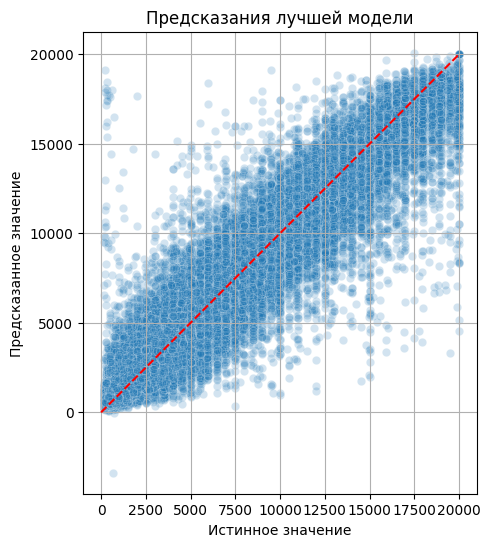

In [91]:
plt.figure(figsize=(6, 6))
# строим диаграмму рассеяния
ax = sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.2)
# проводим пунктирную диагональную линию
ax.plot([0, y_test.max()], [0, y_test.max()], 'r--')

ax.set_xlabel('Истинное значение')
ax.set_ylabel('Предсказанное значение')
ax.set_title('Предсказания лучшей модели')
ax.grid()
ax.set_aspect('equal')

На диаграмме рассеяния заметно, что выбросы в предсказаниях лучшей модели чаще встречаются вблизи границ диапазона цен: около 0 и вблизи 20000 евро. Бросается в глаза одиночный выброс с отрицательным предсказанным значением. Посмотрим, что это за объект.

In [92]:
# объект в тестовой выборке с предсказанной ценой меньше -1000 евро
outlier = X_test.join(y_test).assign(**{'predicted_price': y_pred_best})[y_pred_best < -1000]
outlier

,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,registration_date,price,predicted_price
8814,convertible,auto,190,a5,30000,petrol,audi,no,2015.333333,647,-3374.381331


Сочетание прогнозирующих признаков вполне адекватное. Надо будет разобраться, почему модель предсказала для этого автомобиля такую цену.

Оценим стабильность и устойчивость лучшей модели, проведя анализ остатков на тестовой выборке. Для этого используем пользовательскую функцию `plot_residuals`.

CPU times: user 12min 27s, sys: 1.01 s, total: 12min 28s
Wall time: 12min 27s


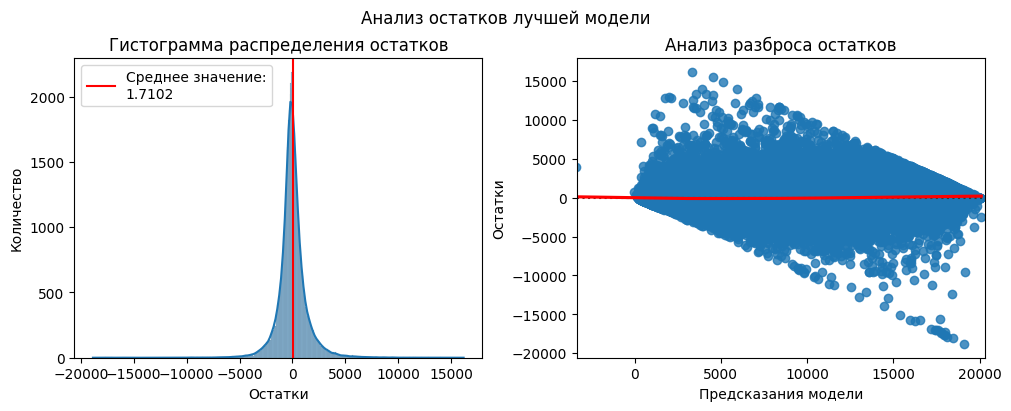

In [93]:
%%time
# строим графики для анализа остатков
fig, _ = plot_residuals(y_test, y_pred_best)
fig.suptitle('Анализ остатков лучшей модели');

Анализ остатков показывает:
- Распределение остатков похоже на нормальное и симметрично относительно нуля, значит модель ошибается в среднем равномерно и  работает стабильно.
- Выбросы в остатках могут объясняться оставшимися в данных аномалиями: слишком низкой ценой автомобиля при "хороших" значениях прогнозирующих признаков и наоборот, слишком высокой ценой при "плохих" признаках.
- Разброс остатков в среднем примерно постоянен при различных значениях целевого признака. Это говорит о высоком качестве модели, поскольку в среднем она ошибается равномерно во всём диапазоне значений величины.
- В остатках наблюдается выраженная структура типа наклонного прямоугольника. Она связана с тем, что цена может быть только положительной.

#### Оценка важности признаков

У модели LightGBM, также как и у дерева решений, есть встроенное средство оценки важности признаков — атрибут `feature_importances_`. Построим график важности признаков для лучшей модели с помощью пользовательской функции `plot_feature_importance`.

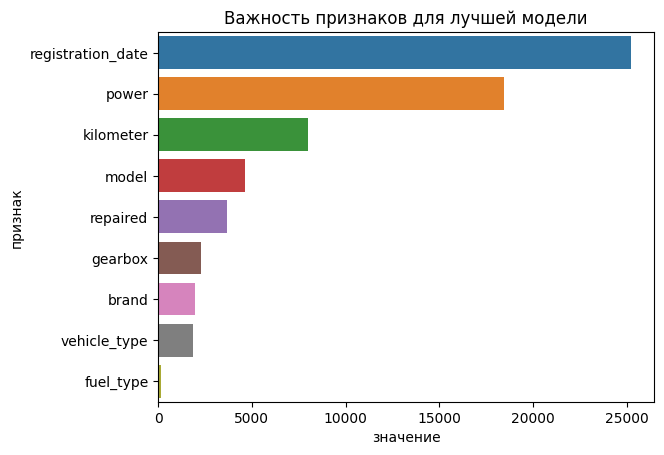

In [94]:
# строим график важности признаков для модели
plot_feature_importance(best_model.feature_importances_, best_model.feature_name_)
plt.title('Важность признаков для лучшей модели');

Наиболее значимый для модели признак — `registration_date` (дата регистрации), характеризующая возраст автомобиля. На втором месте по важности — `power` (мощность двигателя), на третьем — `kilometer` (пробег). Признак `fuel_type` (тип топлива) для предсказания цены автомобиля оказался не важен.

Естественно предпологать, что характер влияния признаков на цену соответствует здравому смыслу: чем больше возраст и пробег автомобиля и чем меньше мощность, тем ниже его цена. Чтобы в этом убедиться, исследуем характер влияния прогнозирующих признаков на целевой средствами библиотеки SHAP. Для объяснения предсказаний модели LightGBM подойдёт класс `shap.TreeExplainer`.

Чтобы сократить время вычислений, возьмём для исследования из тестовой выборки подвыборку размером 1000 записей. 

In [95]:
%%time
# инициализируем объект shap.TreeExplainer
shap_explainer = shap.TreeExplainer(best_model, feature_perturbation='tree_path_dependent')
# вычисляем значения Шепли для части тестовой выборки
shap_values = shap_explainer(X_test.sample(1000, random_state=RANDOM_STATE))

CPU times: user 3min 7s, sys: 262 ms, total: 3min 7s
Wall time: 53.2 s


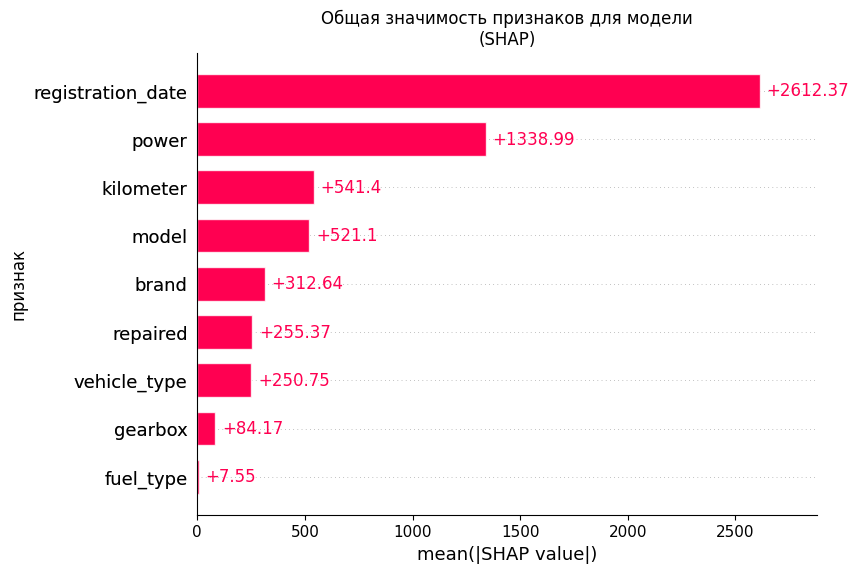

In [96]:
# строим график общей значимости признаков
shap.plots.bar(shap_values, max_display=len(X.columns), show=False) 
# оформляем график
plt.ylabel('признак', fontsize='large')
plt.title('Общая значимость признаков для модели\n(SHAP)');

Топ-3 признаков по важности для модели те же самые. Различия в оценке важности могут быть связаны с малым размером взятой для исследования подвыборки.

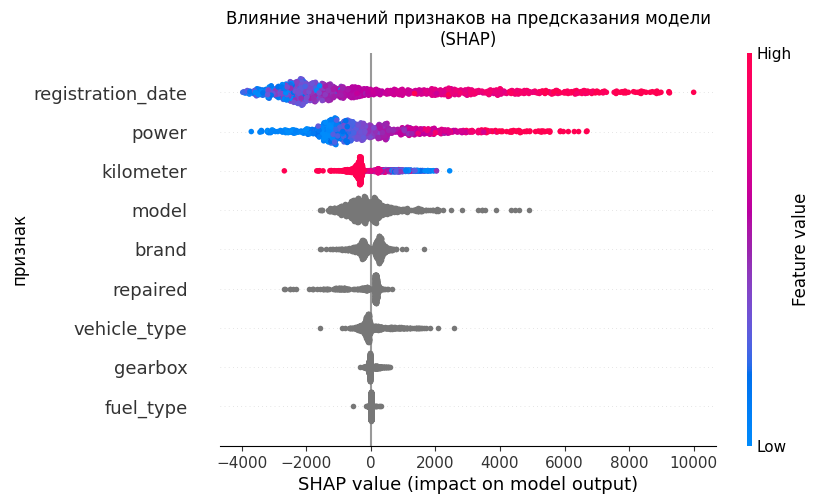

In [97]:
# строим график, который показывает влияние значений признаков 
# на предсказания целевого признака для каждого объекта
shap.plots.beeswarm(shap_values, max_display=len(X.columns), show=False)
# оформляем график
plt.ylabel('признак', fontsize='large')
plt.title('Влияние значений признаков на предсказания модели\n(SHAP)');

Очевидные предположения о характере влияния признаков на цену подтвердились. 

Выясним, почему модель предсказала такую цену для обнаруженного выброса с сильно отрицательной ценой.

In [98]:
# вычисляем значения Шепли для выброса
shap_values_outlier = shap_explainer(X_test.loc[[outlier.index[0]]])

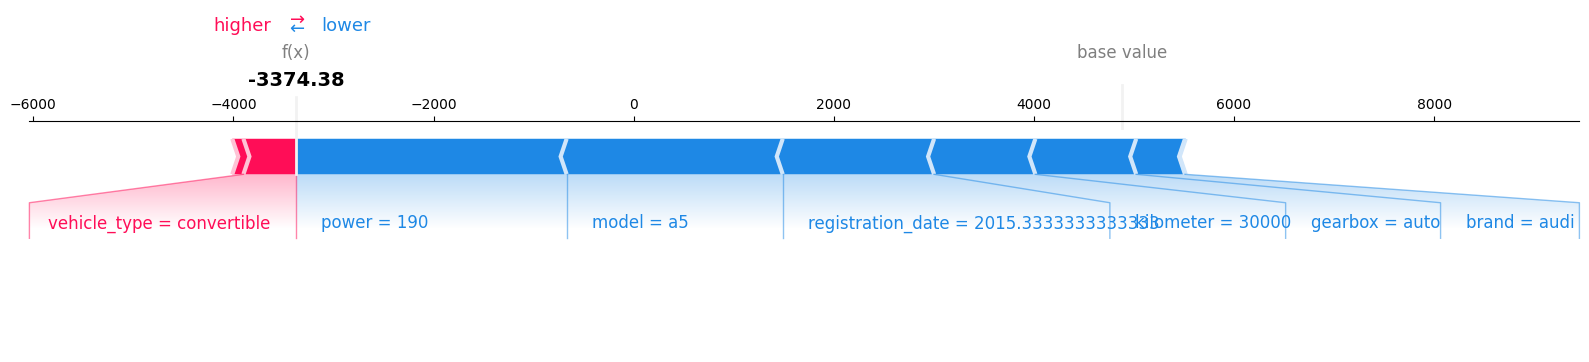

In [99]:
# строим график, который показывает влияние значений признаков 
# на предсказания целевого признака для конкретного объекта
shap.plots.force(shap_values_outlier[0, ...], matplotlib=True)

Видимо, модель немного переобучилась, если данные значения признаков приводят к такому результату прогноза цены.

К сожалению, из-за того, что признаки `gearbox` (тип коробки передач) и `repaired` (была ли машина в ремонте), имеющие по 2 уникальных значения, которые можно упорядочить ('manual', 'unknown', 'auto' для `gearbox` и  'no', 'unknown', 'yes' `repaired`) рассматривались как категориальные, то по данному графику нельзя проверить характер их влияния на цену автомобиля. Для этого нужно закодировать эти признаки в данных числами.

Подготовим данные с кодированными признаками `gearbox` и `repaired` и повторно обучим на них лучшую модель.

In [100]:
# признаки для кодирования
columns_to_encode = ['gearbox', 'repaired']

# инициализируем кодировщик
encoder_ = OrdinalEncoder(
    categories=[
        ['manual', 'unknown', 'auto'],
        ['no', 'unknown', 'yes']
    ]
)
# кодируем категориальные признаки
X_train_encoded_, X_test_encoded_ = encode_features(
    encoder_, columns_to_encode, X_train, X_test)

# обучаем модель на тренировочной выборке
# с кодированными признаками
best_model_ = clone(best_model).fit(X_train_encoded_, y_train, **fit_params);

In [101]:
%%time
# инициализируем объект shap.TreeExplainer
shap_explainer = shap.TreeExplainer(best_model_, feature_perturbation='tree_path_dependent')
# вычисляем значения Шепли для части тестовой выборки
shap_values = shap_explainer(X_test_encoded_.sample(1000, random_state=RANDOM_STATE))

CPU times: user 3min 7s, sys: 233 ms, total: 3min 7s
Wall time: 53.1 s


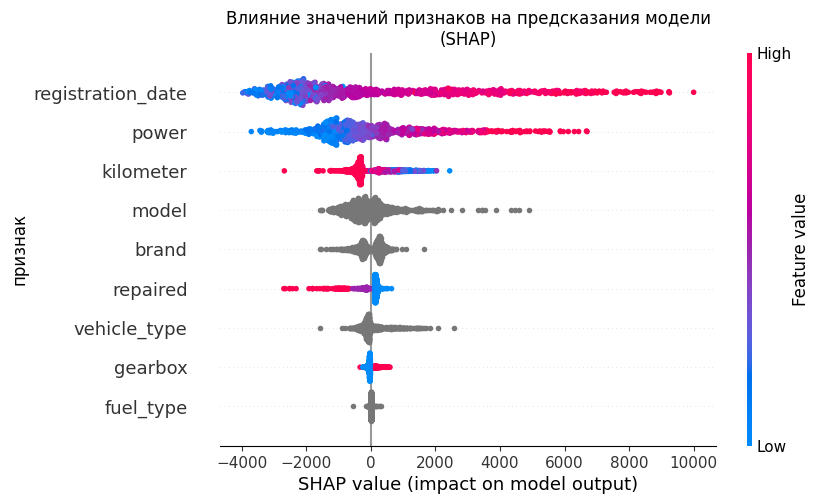

In [102]:
# строим график, который показывает влияние значений признаков 
# на предсказания целевого признака для каждого объекта
shap.plots.beeswarm(shap_values, max_display=len(X.columns), show=False)
# оформляем график
plt.ylabel('признак', fontsize='large')
plt.title('Влияние значений признаков на предсказания модели\n(SHAP)');

Теперь характер влияния всех признаков стал очевиден. Действительно, факт ремонта отрицательно влияет на цену, а автомобили с автоматической коробкой передач в среднем дороже, чем с ручной.

### Выводы

1. Проведено сравнение полученных моделей по важным для заказчика характеристикам: качеству предсказания, времени обучения модели, времени предсказания модели. В зависимости от желаемого баланса между характеристиками возможны разные решения:
    - Если в приоритете **качество модели**, то следует выбрать оптимизированную модель LightGBM.
    - Если в приоритете **время обучения модели** и можно пожертвовать качеством предсказаний, то следует выбрать модель LightGBM с настройками по умолчанию. 
    - Если же в приоритете **время предсказания** и можно пожертвовать качеством предсказаний и скоростью обучения, то следует выбрать оптимизированную модель CatBoost.

2. По совокупности характеристик **лучшая модель** — это оптимизированную модель LightGBM, которая обеспечивает наилучшее качество предсказаний и при этом приемлемые и сбалансированные значения времени обучения и предсказания.

3. Проведён анализ выбранной лучшей модели на тестовой выборке.
    - Метрика RMSE на тестовой выборке получилась даже меньше, чем при кросс-валидации на тренировочной. Значит, модель не переобучилась.
    - Адекватность модели подтверждена её сравнением с дамми-моделью, которая всегда предсказывает константу — среднее значение целевого признака в тренировочной выборке. Дамми-модель показала намного худшее качество: RMSE на тестовой выборке более чем в 3 раза больше.
    - Анализ остатков показал стабильность и устойчивость предсказаний лучшей модели. Однако иногда модель может выдавать отрицательные предсказания цены, которые нужно приводить к нулю, например, с помощью метода `numpy.ndarray.clip`.
    - Оценка важности признаков для лучшей модели показала, что наиболее значимыми признаками для предсказания цены автомобиля являются (в порядке убывания важности): дата регистрации (т.е возраст автомобиля), мощность двигателя и пробег.
    - Характер влияния на цену автомобиля каждого из количественных, а также бинарных категориальных признаков (ручная или автоматическая коробка передач, факт пребывания в ремонте) соответствует здравому смыслу.

## Общий вывод

1. В проекте была поставлена **задача** на основании данных о технических характеристиках, комплектации и ценах автомобилей построить модель, которая будет прогнозировать рыночную стоимость автомобиля по его характеристикам. При этом для заказчика важны качество предсказания, время обучения и предсказания модели.

2. Качество предоставленных исходных данных оказалось не идеально: в данных имеются дубликаты записей, пропущенные значения, аномалии, неинформативные признаки.

3. С целью повышения качества данных, которые будут использованы для обучения и оценки качества моделей, проведена **предобработка данных**:
    - Удалены полные дубликаты записей.
    - Удалены неинформативные признаки, которые не могут влиять не целевой — цену автомобиля.
    - Заполнены пропущенные значения, присутствовавшие в категориальных признаках, значением-заполнителем `unknown`.
    - Устранены неявные дубликаты значений признака `fuel_type`.
    - Данные очищены от обнаруженных нереальных значений признаков `price`, `power` и признака `registration_year`, а также отфильтрованы от редких значений этих признаков.
    - Признаки `registration_year` и `registration_month` объединены в новый признак `registration_date` — год регистрации с добавлением доли года, соответствующей месяцу регистрации. Записи с отсутствующим месяцем регистрации приведены к середине соответствующего года. Новый количественный признак `registration_date` более точно характеризует возраст автомобиля.
    
4. Выполнена **подготовка данных** для обучения и оценки качества моделей.
    - Категориальные текстовые признаки в данных приведены к типу данных `category`, чтобы модель LightGBM могла работать с ними без предварительного кодирования.
    - Данные разделены на на тренировочную и тестовую выборки с выделением целевого признака `price` в отдельную переменную. Анализ корреляций между признаками в тренировочной и тестовой выборках показал, что различия коэффициентов корреляции в выборках пренебрежимо малы.
    - Выполнено кодирование категориальных признаков в данных с помощью `OrdinalEncoder` для работы с моделями, которые не могут работать с категориальными признаками напрямую. Также подготовлен трансформер для кодирования признаков, который включается в пайплайн моделей, требующих кодирования категориальных признаков, при измерении времени обучения и предсказания.

5. Поскольку в данных преобладают категориальные признаки, решено использовать для прогнозирования цены автомобиля модели, основанные на деревьях решений. Рассмотрены модели 4 классов: одиночное дерево решений, случайный лес, а также модели градиентного бустинга на деревьях решений из библиотек LightGBM и CatBoost. Для всех типов моделей подобраны оптимальные значения некоторых гиперпараметров, обеспечивающие минимальное среднее значение метрики RMSE при кросс-валидации на тренировочной выборке.
    - Для анализа отобраны 6 моделей:
        - `DecisionTreeRegressor` с оптимизированными значениями гиперпараметров `max_depth`и `min_samples_leaf`;
        - `RandomForestRegressor` с оптимизированными значениями гиперпараметров `max_depth`, `min_samples_leaf` и `max_features`;
        - `LGBMRegressor` с настройками по умолчанию,
        - `LGBMRegressor` с оптимизированными значениями гиперпараметров `min_data_in_leaf`и `num_leaves`,
        - `CatBoostRegressor` с гиперпараметром `iterations = 100` и остальными настройками по умолчанию,
        - `CatBoostRegressor` с гиперпараметром `iterations = 100` и оптимизированными значениями гиперпараметров `learning_rate` и `max_depth`.
    - Для каждой из отобранных моделей получены значения характеристик для сравнения:
        - среднее значение метрики RMSE при кросс-валидации на тренировочной выборке;
        - среднее время обучения на тренировочной выборке;
        - среднее время предсказания для одной случайно выбранной записи из тестовой выборки.

6. Сравнение полученных моделей по важным для заказчика характеристикам показало:
    - Если в приоритете **качество модели**, то следует выбрать оптимизированную модель LightGBM.
    - Если в приоритете **время обучения модели** и можно пожертвовать качеством предсказаний, то следует выбрать модель LightGBM с настройками по умолчанию. 
    - Если же в приоритете **время предсказания** и можно пожертвовать качеством предсказаний и скоростью обучения, то следует выбрать оптимизированную модель CatBoost.

7. По совокупности характеристик выбрана **лучшая модель** — оптимизированную модель LightGBM, которая обеспечивает наилучшее качество предсказаний и при этом приемлемые и сбалансированные значения времени обучения и предсказания. 

8. Проведён анализ выбранной лучшей модели на тестовой выборке:
    - Метрика RMSE на тестовой выборке получилась не намного больше, чем при кросс-валидации на тренировочной. Значит, модель не переобучилась.
    - Адекватность модели подтверждена её сравнением с дамми-моделью.
    - Анализ остатков показал стабильность и устойчивость предсказаний лучшей модели. Однако иногда модель может выдавать отрицательные предсказания цены, которые нужно приводить к нулю.
    - Оценка важности признаков для лучшей модели показала, что наиболее значимыми признаками для предсказания цены автомобиля являются (в порядке убывания важности): дата регистрации (т.е возраст автомобиля), мощность двигателя и пробег.
    - Характер влияния на цену автомобиля каждого из количественных, а также бинарных категориальных признаков (ручная или автоматическая коробка передач, факт пребывания в ремонте) соответствует здравому смыслу.


**Дополнительные рекомендации заказчику:**
- Для повышения качества предсказаний прогнозирующей модели нужно повысить качество исходных данных, используемых для её обучения. Для этого нужно ввести дополнительные проверки корректности вводимых пользователем значений при заполнении анкеты. Особенно это касается наиболее значимых для модели признаков: дата регистрации (год и месяц) и мощность двигателя. Также желательно увеличить количество возможных для ввода значений пробега (сейчас их всего 13). 